In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torchsummary import summary
import os

In [16]:
DATA_DIR = 'data/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [17]:
def random_transformation(im):
    """Randomly rotate or flip the image"""
    i = np.random.randint(8)
    if i == 0 :
        return im
    if i == 1 :
        return np.rot90(im, axes=(0,1), k=1)
    if i == 2 :
        return np.rot90(im, axes=(0,1), k=2)
    if i == 3 :
        return np.rot90(im, axes=(0,1), k=3)
    if i == 4:
        return np.flip(im, axis=1)
    if i == 5:
        return np.flip(np.rot90(im, axes=(0,1), k=1))
    if i == 6:
        return np.flip(np.rot90(im, axes=(0,1), k=2))
    if i == 7:
        return np.flip(np.rot90(im, axes=(0,1), k=3))

In [18]:
class HackathonDataset(Dataset):
    """Hackathon Dataset"""   
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with paths and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform    
        
    def __len__(self):
        return len(self.file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        img_file = self.file.iloc[idx]["image_file_name"]        
        if "22NCL" in img_file:
            img_dir= "guyane/guyane/"
        elif "28PCC" in img_file:
            img_dir = "saint_louis/saint_louis/"  
        elif "29SMD" in img_file:
            img_dir = "dataset_29SMD/dataset_29SMD/"  
        elif "29TNE" in img_file:
            img_dir = "dataset_29TNE/dataset_29TNE/"
        else:
            raise Exception('There is something wrong with image name')    
        image = np.load(self.root_dir + img_dir + img_file + ".npy")
        image = random_transformation(image)  # Add a random permutation of the image
        image = np.moveaxis(image, -1, 0)  # Permute dimensions in order to have Cin, H, W instead of H, W, Cin
        image = image.astype(np.float32)  # We work with float (float32), not double (float64)
        target = self.file.iloc[idx]["z"]
        target = target.astype(np.float32)  # We work with float (float32), not double (float64)
        sample = {'image': image, 'z': target, "image_file_name": img_file}
        if self.transform:
            sample = self.transform(sample)        
        return sample

In [19]:
class Net(nn.Module):
    """Used Network"""

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(6400, 1024)  
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1)
        self.relu4 = nn.ReLU()
        
    def forward(self, x):
        """Given a tensor X of shape (Batch_size, C_in, H, W), compute the output tensor, of shape (Batch_size, )"""
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.flatten(start_dim=1)  # Flatten the 3 last dimensions, keep the 1 dimension (batch_size)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = x.flatten()  # The output dimension should be (Batch_size, ) and not (Batch_size, 1) 
        return x

In [24]:
n_epochs = 2
batch_size = 8

In [25]:
dataset = HackathonDataset(DATA_DIR + 'mixed_train.csv', DATA_DIR)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 2)
val_dataset = HackathonDataset(DATA_DIR + 'mixed_validation.csv', DATA_DIR)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 2)
model = Net()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [26]:
summary(model, (4, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]             592
              ReLU-2           [-1, 16, 40, 40]               0
         MaxPool2d-3           [-1, 16, 20, 20]               0
            Conv2d-4           [-1, 64, 20, 20]           9,280
              ReLU-5           [-1, 64, 20, 20]               0
         MaxPool2d-6           [-1, 64, 10, 10]               0
            Linear-7                 [-1, 1024]       6,554,624
              ReLU-8                 [-1, 1024]               0
            Linear-9                    [-1, 1]           1,025
             ReLU-10                    [-1, 1]               0
Total params: 6,565,521
Trainable params: 6,565,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.89
Params size (MB): 25.05
Estima

In [27]:
print_frequency = 5

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    # Print Epoch
    print(f"Epoch {epoch + 1}/{n_epochs}")
    
    # Training loop
    for it, batch in enumerate(dataloader):
                
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward propagation through the network
        out = model(batch["image"].to(DEVICE))
        
        # Calculate the loss
        loss = torch.sqrt(criterion(out, batch["z"].to(DEVICE)))  # We take square root because RMSE is the competition's metric
        
        # Track batch loss
        train_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
        #=====Printing part======
        if (it+1)%(len(dataloader) // print_frequency) == 0:
            print(f"Number of sample viewed : {it*batch_size}")
            print(f"Current training loss : {np.mean(train_losses[-len(dataloader)//print_frequency:-1])}")
    
    # Validation loop
    for it, batch in enumerate(val_dataloader):
                
        # Forward propagation through the network
        out = model(batch["image"].to(DEVICE))
        
        # Calculate the loss
        loss = torch.sqrt(criterion(out, batch["z"].to(DEVICE)))  # We take square root because RMSE is the competition's metric
        
        # Track batch loss
        val_losses.append(loss.item())
    
    print(f"Current validation loss : {np.mean(val_losses[-int(len(val_dataloader)*0.8):-1])}")

Epoch 1/2
Number of sample viewed : 11384
Current training loss : 7.78714467561002
Number of sample viewed : 22776
Current training loss : 7.084986387678747
Number of sample viewed : 34168
Current training loss : 6.994531702626957
Number of sample viewed : 45560
Current training loss : 6.881949476814002
Number of sample viewed : 56952
Current training loss : 6.808215212621046
Current validation loss : 7.262968076956727
Epoch 2/2
Number of sample viewed : 11384
Current training loss : 6.781410131812765
Number of sample viewed : 22776
Current training loss : 6.790356549821543
Number of sample viewed : 34168
Current training loss : 6.752316254410851
Number of sample viewed : 45560
Current training loss : 6.744468637899066
Number of sample viewed : 56952
Current training loss : 6.64738193288278
Current validation loss : 5.021107700937058


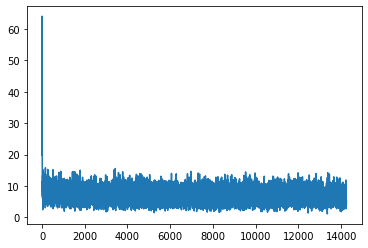

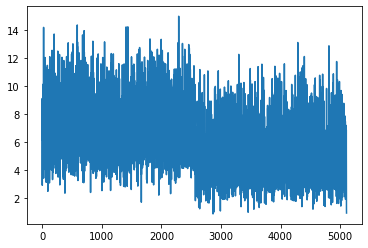

In [28]:
plt.plot(train_losses)
plt.show()
plt.plot(val_losses)
plt.show()

# Evaluation on Test Data

In [29]:
test_dataset = HackathonDataset(DATA_DIR + 'mixed_test.csv', DATA_DIR)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count() - 2)
kaggle_df = pd.DataFrame(columns=['image_file_name', "z"])

In [30]:
data = []

for it, batch in enumerate(test_dataloader):
    out = model(batch["image"].to(DEVICE)).cpu().detach().numpy()
    img_file_names = batch["image_file_name"]
    for i in range(len(img_file_names)):
        data.append([img_file_names[i], out[i]])

kaggle_df = pd.DataFrame(data, columns=['image_id', 'predicted_z'])

In [31]:
kaggle_df.to_csv('predictions/prediction-' + datetime.now().strftime("%d-%m-%y:%H-%M") + '.csv', index=False)